In [1]:
!pip install seaborn
!pip install tensorflow

In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Regression Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error, median_absolute_error
)

# PySwarms
import pyswarms as ps

In [4]:
# Set Random Seeds for Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries imported and seeds set for regression task.")

Libraries imported and seeds set for regression task.


In [6]:
# Load the JSON data
json_file_path = 'autolist_car_details.json' 

try:
    df_raw = pd.read_json(json_file_path, encoding='utf-8')
    print(f"Successfully loaded {json_file_path}")
    print(f"Dataset shape: {df_raw.shape}")
except Exception as e:
    print(f"ERROR: An error occurred while loading the JSON file: {e}")
    # exit()

# Feature Engineering
if 'df_raw' in locals():
    df_processed = df_raw.copy()

    df_processed['Year'] = df_processed['Name'].str.extract(r'(\d{4})', expand=False).astype(float)
    df_processed['Make'] = df_processed['Name'].str.extract(r'\d{4}\s(\w+)', expand=False)

    TARGET_COLUMN = 'Price'
    cols_to_drop = [
        'Scraped_URL', 'Name', 'PricePerMonth', 'Location', 'Trim',
        'Engine', 'VIN', 'Stock_Number', 'Spec_Cabin', 'Spec_Bed',
        'Spec_Rear_Wheel', 'Spec_Fuel_Type', 'Doors', 'Spec_Gas_Mileage'
    ]
    df_processed.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    df_processed.dropna(subset=[TARGET_COLUMN, 'Mileage', 'Year', 'Make'], inplace=True)

    print("\n--- Feature Engineering & Cleaning Complete (Revised) ---")
    print(f"Shape after cleaning: {df_processed.shape}")
    print("\nValue counts for new 'Make' column:")
    print(df_processed['Make'].value_counts().head(10))
    print("\nData Info:")
    df_processed.info()
else:
    print("df_raw not found, skipping processing.")

Successfully loaded autolist_car_details.json
Dataset shape: (21198, 22)

--- Feature Engineering & Cleaning Complete (Revised) ---
Shape after cleaning: (21198, 10)

Value counts for new 'Make' column:
Make
Jeep         6824
Ford         3222
Chevrolet    1981
Toyota       1196
Ram           880
GMC           830
Mercedes      710
Porsche       612
Land          406
Nissan        354
Name: count, dtype: int64

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21198 entries, 0 to 21197
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           21198 non-null  int64  
 1   Transmission    20569 non-null  object 
 2   Drivetrain      19211 non-null  object 
 3   Exterior_Color  20679 non-null  object 
 4   Interior_Color  18769 non-null  object 
 5   Condition       21198 non-null  object 
 6   Body_Style      21110 non-null  object 
 7   Mileage         21198 non-null  int64  
 8   Year      

In [7]:
# Define Features (X) and Target (y)
if 'df_processed' in locals():
    X = df_processed.drop(columns=[TARGET_COLUMN])
    y = df_processed[TARGET_COLUMN]

    # Identify Numerical and Categorical Features
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()

    print("\n--- Preprocessing Setup ---")
    print(f"Numerical features for model: {numerical_features}")
    print(f"Categorical features for model: {categorical_features}")

    # Create Preprocessing Pipelines
    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Create the full preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='passthrough'
    )

    # Train-Test Split 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED
    )

    print("\n--- Train Test Split ---")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


    # Apply Preprocessing
    X_train_processed = preprocessor.fit_transform(X_train)

    X_test_processed = preprocessor.transform(X_test)

    print("\n--- Preprocessing Applied ---")
    print(f"Shape of X_train_processed: {X_train_processed.shape}")
    print(f"Shape of X_test_processed: {X_test_processed.shape}")

    # Define input_dim for the Neural Network
    input_dim = X_train_processed.shape[1]
    print(f"\nInput dimension for NN: {input_dim}")

    # Store baseline data for the final comparison table
    baseline_model = None
    baseline_metrics = {}
    pso_optimized_model = None
    pso_optimized_metrics = {}

else:
    print("ERROR: df_processed not found. Cannot proceed.")


--- Preprocessing Setup ---
Numerical features for model: ['Mileage', 'Year']
Categorical features for model: ['Transmission', 'Drivetrain', 'Exterior_Color', 'Interior_Color', 'Condition', 'Body_Style', 'Make']

--- Train Test Split ---
X_train shape: (16958, 9), y_train shape: (16958,)
X_test shape: (4240, 9), y_test shape: (4240,)

--- Preprocessing Applied ---
Shape of X_train_processed: (16958, 3582)
Shape of X_test_processed: (4240, 3582)

Input dimension for NN: 3582



--- Phase 2: Building a Baseline Regression Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       458,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,993 (1.79 MB)

 Trainable params: 468,993 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17368309760.0000 - mae: 61650.2109 - mse: 17368309760.0000 - val_loss: 17249478656.0000 - val_mae: 45179.4023 - val_mse: 17249478656.0000
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13563735040.0000 - mae: 44705.4727 - mse: 13563735040.0000 - val_loss: 12580589568.0000 - val_mae: 46206.6328 - val_mse: 12580589568.0000
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10124993536.0000 - mae: 42279.0859 - mse: 10124993536.0000 - val_loss: 10408785920.0000 - val_mae: 36372.0156 - val_mse: 10408785920.0000
Epoch 4/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8349812736.0000 - mae: 34308.5664 - mse: 8349812736.0000 - val_loss: 9599676416.0000 - val_mae: 32039.5449 - val_mse: 9599676416.0000
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7698608128.0000 - mae: 30404.8750 - mse: 7698608128.0000 - val_loss: 9266780160.0000 - val_mae: 29093.6445 - val_mse: 9266780160.0000
Epoch 6/100
2

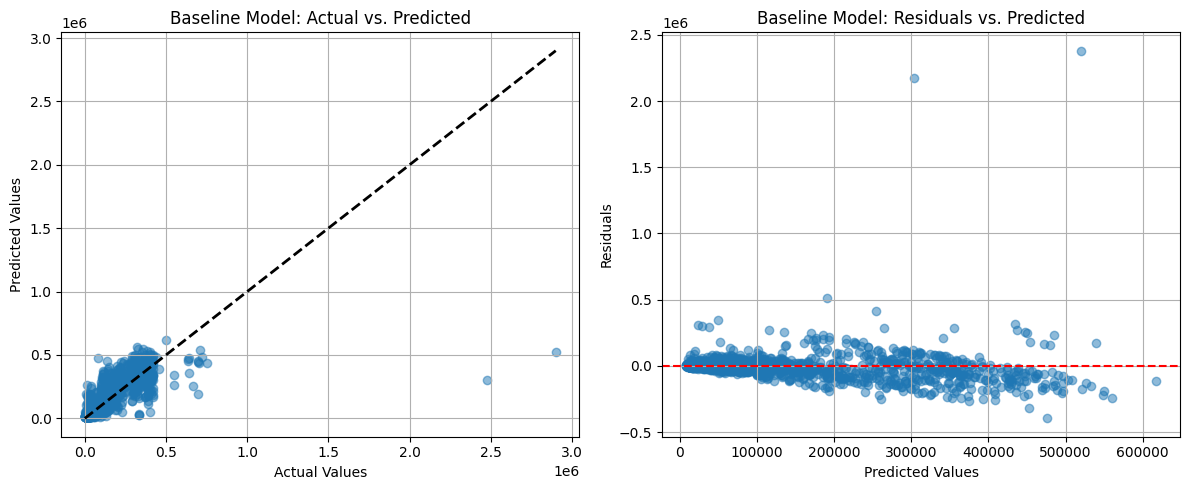

In [8]:
# Define a Reusable Evaluation Function
def evaluate_regression_model(model_name, model_to_eval, X_test_data, y_test_data):
    print(f"\n--- Evaluating {model_name} ---")
    y_pred_eval = model_to_eval.predict(X_test_data).flatten()

    metrics = {}
    metrics['MSE'] = mean_squared_error(y_test_data, y_pred_eval)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE'] = mean_absolute_error(y_test_data, y_pred_eval)
    metrics['R2'] = r2_score(y_test_data, y_pred_eval)
    metrics['MedAE'] = median_absolute_error(y_test_data, y_pred_eval)
    
    # Calculate MAPE safely
    non_zero_mask = y_test_data != 0
    if np.any(non_zero_mask):
        metrics['MAPE'] = mean_absolute_percentage_error(y_test_data[non_zero_mask], y_pred_eval[non_zero_mask]) * 100
    else:
        print("Warning: y_test contains all zeros, MAPE is undefined.")
        metrics['MAPE'] = np.nan

    print(f"{model_name} Test MSE: {metrics['MSE']:.2f}")
    print(f"{model_name} Test RMSE: {metrics['RMSE']:.2f}")
    print(f"{model_name} Test MAE: {metrics['MAE']:.2f}")
    print(f"{model_name} Test R-squared (R²): {metrics['R2']:.4f}")
    print(f"{model_name} Test MAPE: {metrics['MAPE']:.2f}%")
    print(f"{model_name} Test MedAE: {metrics['MedAE']:.2f}")
    
    # Plotting
    plt.figure(figsize=(12, 5))
    
    # Actual vs. Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_data, y_pred_eval, alpha=0.5)
    plt.plot([y_test_data.min(), y_test_data.max()], [y_test_data.min(), y_test_data.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name}: Actual vs. Predicted')
    plt.grid(True)

    # Residuals Plot
    residuals = y_test_data - y_pred_eval
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred_eval, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name}: Residuals vs. Predicted')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    return metrics, y_pred_eval

# Define and Train the Baseline Model
print("\n--- Phase 2: Building a Baseline Regression Model ---")

# Define architecture
baseline_model = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1) 
])

# Compile model
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

baseline_model.summary()

# Early stopping
baseline_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train model
history_baseline = baseline_model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=64, 
    validation_split=0.2,
    callbacks=[baseline_early_stopping],
    verbose=1
)

# Evaluate the Baseline Model
baseline_metrics, _ = evaluate_regression_model(
    "Baseline Model", baseline_model, X_test_processed, y_test
)

In [9]:
# Further split X_train_processed for PSO's internal training and validation
X_train_pso, X_val_pso, y_train_pso, y_val_pso = train_test_split(
    X_train_processed, y_train,
    test_size=0.25,
    random_state=SEED
)

print("\n--- PSO Optimization Setup for Regression ---")
print(f"PSO training set size: {X_train_pso.shape}")
print(f"PSO validation set size: {X_val_pso.shape}")

#  Define Hyperparameter Search Space for PSO
min_bounds_regr = np.array([32,  16, 0.1,  0.1,  0.0001, 32])
max_bounds_regr = np.array([256, 128, 0.5,  0.5,  0.01,   128])
bounds_pso_regr = (min_bounds_regr, max_bounds_regr)
n_dimensions_pso_regr = len(min_bounds_regr)

# Define PSO Objective Function for Regression
pso_iteration_count_regr = 0

def nn_fitness_function_pso_regression(params_particle):
    global pso_iteration_count_regr
    pso_iteration_count_regr += 1

    # Unpack hyperparameters
    neurons_l1 = int(round(params_particle[0]))
    neurons_l2 = int(round(params_particle[1]))
    dropout_l1 = float(params_particle[2])
    dropout_l2 = float(params_particle[3])
    learning_rate = float(params_particle[4])
    batch_size = int(round(params_particle[5]))

    print(f"\nPSO Eval {pso_iteration_count_regr}: N1={neurons_l1}, N2={neurons_l2}, "
          f"DR1={dropout_l1:.3f}, DR2={dropout_l2:.3f}, LR={learning_rate:.5f}, BS={batch_size}", end="")

    tf.keras.backend.clear_session()
    np.random.seed(SEED + pso_iteration_count_regr)
    tf.random.set_seed(SEED + pso_iteration_count_regr)

    model_pso_eval = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_l1, activation='relu'),
        Dropout(dropout_l1),
        Dense(neurons_l2, activation='relu'),
        Dropout(dropout_l2),
        Dense(1) 
    ])

    model_pso_eval.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error' 
    )
    
    pso_eval_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    
    history_pso_eval = model_pso_eval.fit(
        X_train_pso, y_train_pso,
        epochs=50, 
        batch_size=batch_size,
        validation_data=(X_val_pso, y_val_pso),
        callbacks=[pso_eval_early_stopping],
        verbose=0
    )

    # The cost is the validation loss (MSE) from the best epoch
    min_val_loss = np.min(history_pso_eval.history['val_loss'])
    print(f" -> Min Val Loss (MSE): {min_val_loss:.2f}")
    
    return min_val_loss

def pso_objective_function_batch_wrapper_regr(particles_batch):
    results = [nn_fitness_function_pso_regression(p) for p in particles_batch]
    return np.array(results)

# Configure and Run PSO
n_particles_pso = 20
pso_iters = 15  

options_pso = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

print(f"\nStarting PSO with {n_particles_pso} particles for {pso_iters} iterations.")

pso_optimizer_regr = ps.single.GlobalBestPSO(
    n_particles=n_particles_pso,
    dimensions=n_dimensions_pso_regr,
    options=options_pso,
    bounds=bounds_pso_regr
)

best_cost_pso, best_params_pso = pso_optimizer_regr.optimize(
    pso_objective_function_batch_wrapper_regr,
    iters=pso_iters,
    verbose=True
)

# Extract and Display Best Hyperparameters
print("\n--- PSO Optimization Finished ---")
print(f"Best cost (min_val_loss MSE) from PSO: {best_cost_pso:.2f}")
print(f"Best hyperparameters from PSO raw: {best_params_pso}")

best_neurons_l1 = int(round(best_params_pso[0]))
best_neurons_l2 = int(round(best_params_pso[1]))
best_dropout_l1 = float(best_params_pso[2])
best_dropout_l2 = float(best_params_pso[3])
best_learning_rate = float(best_params_pso[4])
best_batch_size = int(round(best_params_pso[5]))

print("\nFormatted Best Hyperparameters from PSO:")
print(f"  Neurons L1: {best_neurons_l1}, Neurons L2: {best_neurons_l2}")
print(f"  Dropout L1: {best_dropout_l1:.4f}, Dropout L2: {best_dropout_l2:.4f}")
print(f"  Learning Rate: {best_learning_rate:.6f}, Batch Size: {best_batch_size}")

2025-06-12 21:08:11,727 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



--- PSO Optimization Setup for Regression ---
PSO training set size: (12718, 3582)
PSO validation set size: (4240, 3582)

Starting PSO with 20 particles for 15 iterations.


pyswarms.single.global_best:   0%|          |0/15


PSO Eval 1: N1=243, N2=123, DR1=0.466, DR2=0.248, LR=0.00025, BS=121WARNING:tensorflow:From C:\Users\Benjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



2025-06-12 21:08:12,291 - tensorflow - WARNING - From C:\Users\Benjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



 -> Min Val Loss (MSE): 7508654592.00

PSO Eval 2: N1=128, N2=124, DR1=0.485, DR2=0.441, LR=0.00302, BS=69 -> Min Val Loss (MSE): 5571479040.00

PSO Eval 3: N1=223, N2=51, DR1=0.168, DR2=0.323, LR=0.00937, BS=99 -> Min Val Loss (MSE): 5612489216.00

PSO Eval 4: N1=160, N2=27, DR1=0.346, DR2=0.496, LR=0.00149, BS=82 -> Min Val Loss (MSE): 5870678016.00

PSO Eval 5: N1=229, N2=99, DR1=0.379, DR2=0.381, LR=0.00366, BS=60 -> Min Val Loss (MSE): 5566291968.00

PSO Eval 6: N1=213, N2=107, DR1=0.447, DR2=0.465, LR=0.00516, BS=80 -> Min Val Loss (MSE): 5590731264.00

PSO Eval 7: N1=211, N2=89, DR1=0.381, DR2=0.418, LR=0.00891, BS=64 -> Min Val Loss (MSE): 5613151232.00

PSO Eval 8: N1=116, N2=27, DR1=0.331, DR2=0.114, LR=0.00471, BS=84 -> Min Val Loss (MSE): 5608966144.00

PSO Eval 9: N1=96, N2=82, DR1=0.112, DR2=0.115, LR=0.00824, BS=67 -> Min Val Loss (MSE): 5597653504.00

PSO Eval 10: N1=60, N2=74, DR1=0.408, DR2=0.186, LR=0.00627, BS=40 -> Min Val Loss (MSE): 5642893824.00

PSO Eval 11: N1

pyswarms.single.global_best:   7%|▋         |1/15, best_cost=5.56e+9

 -> Min Val Loss (MSE): 5641174528.00

PSO Eval 21: N1=235, N2=117, DR1=0.473, DR2=0.351, LR=0.00687, BS=107 -> Min Val Loss (MSE): 5604413440.00

PSO Eval 22: N1=127, N2=121, DR1=0.248, DR2=0.104, LR=0.00528, BS=67 -> Min Val Loss (MSE): 5601425920.00

PSO Eval 23: N1=216, N2=60, DR1=0.252, DR2=0.210, LR=0.00681, BS=91 -> Min Val Loss (MSE): 5693231616.00

PSO Eval 24: N1=156, N2=30, DR1=0.449, DR2=0.308, LR=0.00411, BS=75 -> Min Val Loss (MSE): 5573697536.00

PSO Eval 25: N1=211, N2=99, DR1=0.217, DR2=0.144, LR=0.00649, BS=58 -> Min Val Loss (MSE): 5590422528.00

PSO Eval 26: N1=203, N2=106, DR1=0.361, DR2=0.363, LR=0.00525, BS=72 -> Min Val Loss (MSE): 5614487040.00

PSO Eval 27: N1=201, N2=89, DR1=0.250, DR2=0.303, LR=0.00261, BS=62 -> Min Val Loss (MSE): 5621041664.00

PSO Eval 28: N1=117, N2=39, DR1=0.211, DR2=0.202, LR=0.00903, BS=76 -> Min Val Loss (MSE): 5597189632.00

PSO Eval 29: N1=97, N2=83, DR1=0.443, DR2=0.179, LR=0.00243, BS=62 -> Min Val Loss (MSE): 5612872192.00

PSO 

pyswarms.single.global_best:  13%|█▎        |2/15, best_cost=5.51e+9

 -> Min Val Loss (MSE): 11014385664.00

PSO Eval 41: N1=202, N2=95, DR1=0.437, DR2=0.410, LR=0.00787, BS=94 -> Min Val Loss (MSE): 5595646976.00

PSO Eval 42: N1=118, N2=104, DR1=0.453, DR2=0.296, LR=0.00782, BS=64 -> Min Val Loss (MSE): 5732713984.00

PSO Eval 43: N1=189, N2=61, DR1=0.325, DR2=0.178, LR=0.00836, BS=85 -> Min Val Loss (MSE): 5600716800.00

PSO Eval 44: N1=152, N2=38, DR1=0.134, DR2=0.479, LR=0.00035, BS=65 -> Min Val Loss (MSE): 7244793856.00

PSO Eval 45: N1=191, N2=90, DR1=0.481, DR2=0.351, LR=0.00017, BS=56 -> Min Val Loss (MSE): 8157311488.00

PSO Eval 46: N1=176, N2=97, DR1=0.286, DR2=0.232, LR=0.00447, BS=65 -> Min Val Loss (MSE): 5624260608.00

PSO Eval 47: N1=158, N2=81, DR1=0.140, DR2=0.144, LR=0.00825, BS=60 -> Min Val Loss (MSE): 5674498048.00

PSO Eval 48: N1=112, N2=53, DR1=0.109, DR2=0.223, LR=0.00749, BS=66 -> Min Val Loss (MSE): 5607238144.00

PSO Eval 49: N1=92, N2=79, DR1=0.330, DR2=0.192, LR=0.00126, BS=58 -> Min Val Loss (MSE): 5674519040.00

PSO Ev

pyswarms.single.global_best:  20%|██        |3/15, best_cost=5.51e+9

 -> Min Val Loss (MSE): 5584755712.00

PSO Eval 61: N1=143, N2=66, DR1=0.359, DR2=0.432, LR=0.00168, BS=82 -> Min Val Loss (MSE): 5685171712.00

PSO Eval 62: N1=99, N2=77, DR1=0.240, DR2=0.123, LR=0.00077, BS=63 -> Min Val Loss (MSE): 5961370112.00

PSO Eval 63: N1=145, N2=61, DR1=0.398, DR2=0.191, LR=0.00081, BS=75 -> Min Val Loss (MSE): 6020347904.00

PSO Eval 64: N1=129, N2=47, DR1=0.306, DR2=0.192, LR=0.00743, BS=58 -> Min Val Loss (MSE): 5596963328.00

PSO Eval 65: N1=147, N2=74, DR1=0.267, DR2=0.153, LR=0.00524, BS=56 -> Min Val Loss (MSE): 5639392256.00

PSO Eval 66: N1=135, N2=83, DR1=0.274, DR2=0.487, LR=0.00628, BS=61 -> Min Val Loss (MSE): 5534754304.00

PSO Eval 67: N1=122, N2=71, DR1=0.454, DR2=0.470, LR=0.00537, BS=59 -> Min Val Loss (MSE): 5541484032.00

PSO Eval 68: N1=102, N2=60, DR1=0.426, DR2=0.229, LR=0.00424, BS=61 -> Min Val Loss (MSE): 5621386752.00

PSO Eval 69: N1=87, N2=75, DR1=0.136, DR2=0.154, LR=0.00646, BS=56 -> Min Val Loss (MSE): 5571294208.00

PSO Eval 

pyswarms.single.global_best:  27%|██▋       |4/15, best_cost=5.47e+9

 -> Min Val Loss (MSE): 5487334400.00

PSO Eval 81: N1=78, N2=50, DR1=0.254, DR2=0.401, LR=0.00863, BS=67 -> Min Val Loss (MSE): 5504665600.00

PSO Eval 82: N1=90, N2=56, DR1=0.437, DR2=0.446, LR=0.00871, BS=62 -> Min Val Loss (MSE): 5591096320.00

PSO Eval 83: N1=98, N2=61, DR1=0.430, DR2=0.163, LR=0.00455, BS=66 -> Min Val Loss (MSE): 5577388032.00

PSO Eval 84: N1=106, N2=49, DR1=0.109, DR2=0.284, LR=0.00723, BS=59 -> Min Val Loss (MSE): 5684982272.00

PSO Eval 85: N1=120, N2=61, DR1=0.447, DR2=0.430, LR=0.00524, BS=54 -> Min Val Loss (MSE): 5545926656.00

PSO Eval 86: N1=86, N2=67, DR1=0.221, DR2=0.273, LR=0.00327, BS=55 -> Min Val Loss (MSE): 5619627008.00

PSO Eval 87: N1=81, N2=61, DR1=0.260, DR2=0.302, LR=0.00606, BS=56 -> Min Val Loss (MSE): 5677335552.00

PSO Eval 88: N1=94, N2=61, DR1=0.186, DR2=0.138, LR=0.00483, BS=54 -> Min Val Loss (MSE): 5599723520.00

PSO Eval 89: N1=83, N2=70, DR1=0.352, DR2=0.440, LR=0.00131, BS=52 -> Min Val Loss (MSE): 5721874944.00

PSO Eval 90: N

pyswarms.single.global_best:  33%|███▎      |5/15, best_cost=5.47e+9

 -> Min Val Loss (MSE): 5586938368.00

PSO Eval 101: N1=244, N2=37, DR1=0.121, DR2=0.282, LR=0.00328, BS=52 -> Min Val Loss (MSE): 5596405760.00

PSO Eval 102: N1=95, N2=54, DR1=0.211, DR2=0.310, LR=0.00779, BS=59 -> Min Val Loss (MSE): 5539354112.00

PSO Eval 103: N1=53, N2=63, DR1=0.430, DR2=0.108, LR=0.00244, BS=56 -> Min Val Loss (MSE): 5617631744.00

PSO Eval 104: N1=104, N2=44, DR1=0.428, DR2=0.321, LR=0.00546, BS=58 -> Min Val Loss (MSE): 5597030912.00

PSO Eval 105: N1=95, N2=49, DR1=0.206, DR2=0.238, LR=0.00648, BS=51 -> Min Val Loss (MSE): 5683693568.00

PSO Eval 106: N1=60, N2=58, DR1=0.153, DR2=0.452, LR=0.00942, BS=50 -> Min Val Loss (MSE): 5520143872.00

PSO Eval 107: N1=65, N2=57, DR1=0.488, DR2=0.475, LR=0.00984, BS=54 -> Min Val Loss (MSE): 5519360000.00

PSO Eval 108: N1=95, N2=59, DR1=0.343, DR2=0.394, LR=0.00959, BS=49 -> Min Val Loss (MSE): 5601653248.00

PSO Eval 109: N1=82, N2=67, DR1=0.474, DR2=0.145, LR=0.00350, BS=49 -> Min Val Loss (MSE): 5633721856.00

PSO E

pyswarms.single.global_best:  40%|████      |6/15, best_cost=5.47e+9

 -> Min Val Loss (MSE): 5548553728.00

PSO Eval 121: N1=124, N2=34, DR1=0.453, DR2=0.172, LR=0.00508, BS=44 -> Min Val Loss (MSE): 5507672576.00

PSO Eval 122: N1=100, N2=53, DR1=0.377, DR2=0.120, LR=0.00109, BS=54 -> Min Val Loss (MSE): 5769564672.00

PSO Eval 123: N1=44, N2=65, DR1=0.390, DR2=0.465, LR=0.00023, BS=47 -> Min Val Loss (MSE): 8855519232.00

PSO Eval 124: N1=107, N2=39, DR1=0.313, DR2=0.292, LR=0.00623, BS=61 -> Min Val Loss (MSE): 5570417152.00

PSO Eval 125: N1=82, N2=41, DR1=0.424, DR2=0.470, LR=0.00301, BS=48 -> Min Val Loss (MSE): 5571831808.00

PSO Eval 126: N1=37, N2=52, DR1=0.480, DR2=0.133, LR=0.00509, BS=45 -> Min Val Loss (MSE): 5592029696.00

PSO Eval 127: N1=55, N2=54, DR1=0.189, DR2=0.115, LR=0.00730, BS=51 -> Min Val Loss (MSE): 5733239808.00

PSO Eval 128: N1=103, N2=51, DR1=0.456, DR2=0.158, LR=0.00099, BS=54 -> Min Val Loss (MSE): 5867125248.00

PSO Eval 129: N1=82, N2=64, DR1=0.166, DR2=0.213, LR=0.00051, BS=49 -> Min Val Loss (MSE): 6405087744.00

PSO

pyswarms.single.global_best:  47%|████▋     |7/15, best_cost=5.47e+9

 -> Min Val Loss (MSE): 5784181760.00

PSO Eval 141: N1=210, N2=33, DR1=0.301, DR2=0.123, LR=0.00856, BS=41 -> Min Val Loss (MSE): 5670760960.00

PSO Eval 142: N1=99, N2=52, DR1=0.447, DR2=0.394, LR=0.00163, BS=49 -> Min Val Loss (MSE): 5689776128.00

PSO Eval 143: N1=65, N2=66, DR1=0.355, DR2=0.231, LR=0.00332, BS=46 -> Min Val Loss (MSE): 5577781248.00

PSO Eval 144: N1=104, N2=41, DR1=0.164, DR2=0.215, LR=0.00398, BS=63 -> Min Val Loss (MSE): 5618434048.00

PSO Eval 145: N1=73, N2=43, DR1=0.209, DR2=0.269, LR=0.00114, BS=47 -> Min Val Loss (MSE): 5845296640.00

PSO Eval 146: N1=34, N2=50, DR1=0.278, DR2=0.302, LR=0.00470, BS=42 -> Min Val Loss (MSE): 5582879744.00

PSO Eval 147: N1=53, N2=54, DR1=0.330, DR2=0.241, LR=0.00031, BS=49 -> Min Val Loss (MSE): 7584428544.00

PSO Eval 148: N1=110, N2=47, DR1=0.444, DR2=0.295, LR=0.00421, BS=65 -> Min Val Loss (MSE): 5604139520.00

PSO Eval 149: N1=84, N2=62, DR1=0.244, DR2=0.222, LR=0.00773, BS=51 -> Min Val Loss (MSE): 5660160512.00

PSO 

pyswarms.single.global_best:  53%|█████▎    |8/15, best_cost=5.45e+9

 -> Min Val Loss (MSE): 5643863552.00

PSO Eval 161: N1=255, N2=42, DR1=0.105, DR2=0.197, LR=0.00572, BS=45 -> Min Val Loss (MSE): 5576777216.00

PSO Eval 162: N1=89, N2=52, DR1=0.405, DR2=0.238, LR=0.00025, BS=47 -> Min Val Loss (MSE): 7838696448.00

PSO Eval 163: N1=92, N2=67, DR1=0.333, DR2=0.368, LR=0.00607, BS=54 -> Min Val Loss (MSE): 5607892992.00

PSO Eval 164: N1=100, N2=44, DR1=0.473, DR2=0.117, LR=0.00146, BS=62 -> Min Val Loss (MSE): 5747175424.00

PSO Eval 165: N1=75, N2=53, DR1=0.101, DR2=0.116, LR=0.00513, BS=49 -> Min Val Loss (MSE): 5668918272.00

PSO Eval 166: N1=38, N2=51, DR1=0.449, DR2=0.449, LR=0.00800, BS=42 -> Min Val Loss (MSE): 5535746048.00

PSO Eval 167: N1=56, N2=56, DR1=0.449, DR2=0.361, LR=0.00074, BS=48 -> Min Val Loss (MSE): 6273318912.00

PSO Eval 168: N1=114, N2=43, DR1=0.331, DR2=0.394, LR=0.00127, BS=77 -> Min Val Loss (MSE): 5871692800.00

PSO Eval 169: N1=86, N2=65, DR1=0.325, DR2=0.185, LR=0.00814, BS=54 -> Min Val Loss (MSE): 5608324608.00

PSO 

pyswarms.single.global_best:  60%|██████    |9/15, best_cost=5.45e+9

 -> Min Val Loss (MSE): 5696392704.00

PSO Eval 181: N1=240, N2=54, DR1=0.377, DR2=0.319, LR=0.00195, BS=52 -> Min Val Loss (MSE): 5604408832.00

PSO Eval 182: N1=81, N2=55, DR1=0.287, DR2=0.500, LR=0.00730, BS=47 -> Min Val Loss (MSE): 5482898944.00

PSO Eval 183: N1=110, N2=65, DR1=0.336, DR2=0.421, LR=0.00167, BS=62 -> Min Val Loss (MSE): 5642883072.00

PSO Eval 184: N1=91, N2=48, DR1=0.288, DR2=0.151, LR=0.00315, BS=59 -> Min Val Loss (MSE): 5628662272.00

PSO Eval 185: N1=81, N2=67, DR1=0.448, DR2=0.475, LR=0.00662, BS=53 -> Min Val Loss (MSE): 5509735424.00

PSO Eval 186: N1=55, N2=58, DR1=0.487, DR2=0.144, LR=0.00631, BS=47 -> Min Val Loss (MSE): 5557283840.00

PSO Eval 187: N1=64, N2=61, DR1=0.105, DR2=0.455, LR=0.00863, BS=49 -> Min Val Loss (MSE): 5582962688.00

PSO Eval 188: N1=109, N2=38, DR1=0.169, DR2=0.362, LR=0.00157, BS=82 -> Min Val Loss (MSE): 5772218368.00

PSO Eval 189: N1=87, N2=70, DR1=0.309, DR2=0.108, LR=0.00631, BS=55 -> Min Val Loss (MSE): 5656270336.00

PSO 

pyswarms.single.global_best:  67%|██████▋   |10/15, best_cost=5.45e+9

 -> Min Val Loss (MSE): 5611087360.00

PSO Eval 201: N1=184, N2=66, DR1=0.177, DR2=0.441, LR=0.00185, BS=59 -> Min Val Loss (MSE): 5589304320.00

PSO Eval 202: N1=73, N2=58, DR1=0.183, DR2=0.334, LR=0.00978, BS=48 -> Min Val Loss (MSE): 5595950080.00

PSO Eval 203: N1=116, N2=63, DR1=0.361, DR2=0.464, LR=0.00460, BS=68 -> Min Val Loss (MSE): 5575882240.00

PSO Eval 204: N1=79, N2=48, DR1=0.491, DR2=0.239, LR=0.00015, BS=55 -> Min Val Loss (MSE): 10831854592.00

PSO Eval 205: N1=85, N2=79, DR1=0.325, DR2=0.395, LR=0.00824, BS=56 -> Min Val Loss (MSE): 5638662144.00

PSO Eval 206: N1=72, N2=65, DR1=0.464, DR2=0.342, LR=0.00211, BS=52 -> Min Val Loss (MSE): 5611843584.00

PSO Eval 207: N1=73, N2=65, DR1=0.170, DR2=0.103, LR=0.00206, BS=50 -> Min Val Loss (MSE): 5613120512.00

PSO Eval 208: N1=102, N2=40, DR1=0.483, DR2=0.317, LR=0.00613, BS=77 -> Min Val Loss (MSE): 5549124608.00

PSO Eval 209: N1=87, N2=76, DR1=0.268, DR2=0.405, LR=0.00670, BS=55 -> Min Val Loss (MSE): 5674697216.00

PSO

pyswarms.single.global_best:  73%|███████▎  |11/15, best_cost=5.4e+9 

 -> Min Val Loss (MSE): 5606322688.00

PSO Eval 221: N1=142, N2=73, DR1=0.375, DR2=0.491, LR=0.00145, BS=62 -> Min Val Loss (MSE): 5648346112.00

PSO Eval 222: N1=73, N2=66, DR1=0.127, DR2=0.157, LR=0.00691, BS=48 -> Min Val Loss (MSE): 5625392128.00

PSO Eval 223: N1=140, N2=65, DR1=0.341, DR2=0.101, LR=0.00766, BS=69 -> Min Val Loss (MSE): 5597256704.00

PSO Eval 224: N1=89, N2=47, DR1=0.123, DR2=0.290, LR=0.00657, BS=49 -> Min Val Loss (MSE): 5598926848.00

PSO Eval 225: N1=94, N2=86, DR1=0.139, DR2=0.283, LR=0.00247, BS=55 -> Min Val Loss (MSE): 5608657920.00

PSO Eval 226: N1=109, N2=73, DR1=0.252, DR2=0.131, LR=0.00868, BS=54 -> Min Val Loss (MSE): 5637171712.00

PSO Eval 227: N1=103, N2=67, DR1=0.325, DR2=0.242, LR=0.00448, BS=53 -> Min Val Loss (MSE): 5586830848.00

PSO Eval 228: N1=111, N2=48, DR1=0.403, DR2=0.244, LR=0.00636, BS=67 -> Min Val Loss (MSE): 5533989888.00

PSO Eval 229: N1=114, N2=80, DR1=0.163, DR2=0.149, LR=0.00315, BS=55 -> Min Val Loss (MSE): 5672606720.00

P

pyswarms.single.global_best:  80%|████████  |12/15, best_cost=5.4e+9

 -> Min Val Loss (MSE): 5625352704.00

PSO Eval 241: N1=120, N2=75, DR1=0.124, DR2=0.469, LR=0.00514, BS=62 -> Min Val Loss (MSE): 5580741120.00

PSO Eval 242: N1=107, N2=75, DR1=0.132, DR2=0.413, LR=0.00056, BS=46 -> Min Val Loss (MSE): 6026848768.00

PSO Eval 243: N1=177, N2=67, DR1=0.285, DR2=0.317, LR=0.00274, BS=63 -> Min Val Loss (MSE): 5613844480.00

PSO Eval 244: N1=136, N2=52, DR1=0.207, DR2=0.306, LR=0.00251, BS=47 -> Min Val Loss (MSE): 5598215680.00

PSO Eval 245: N1=96, N2=81, DR1=0.425, DR2=0.162, LR=0.00487, BS=49 -> Min Val Loss (MSE): 5646326784.00

PSO Eval 246: N1=145, N2=78, DR1=0.399, DR2=0.442, LR=0.00351, BS=51 -> Min Val Loss (MSE): 5556273664.00

PSO Eval 247: N1=129, N2=67, DR1=0.454, DR2=0.353, LR=0.00496, BS=53 -> Min Val Loss (MSE): 5553134080.00

PSO Eval 248: N1=137, N2=56, DR1=0.290, DR2=0.151, LR=0.00365, BS=54 -> Min Val Loss (MSE): 5609027584.00

PSO Eval 249: N1=147, N2=82, DR1=0.456, DR2=0.334, LR=0.00011, BS=51 -> Min Val Loss (MSE): 10350619648.00

pyswarms.single.global_best:  87%|████████▋ |13/15, best_cost=5.4e+9

 -> Min Val Loss (MSE): 5865356800.00

PSO Eval 261: N1=120, N2=67, DR1=0.282, DR2=0.377, LR=0.00172, BS=57 -> Min Val Loss (MSE): 5627271168.00

PSO Eval 262: N1=156, N2=81, DR1=0.154, DR2=0.245, LR=0.00258, BS=45 -> Min Val Loss (MSE): 5651270656.00

PSO Eval 263: N1=199, N2=68, DR1=0.225, DR2=0.118, LR=0.00440, BS=59 -> Min Val Loss (MSE): 5638984704.00

PSO Eval 264: N1=186, N2=56, DR1=0.309, DR2=0.280, LR=0.00249, BS=50 -> Min Val Loss (MSE): 5613333504.00

PSO Eval 265: N1=121, N2=73, DR1=0.282, DR2=0.128, LR=0.00547, BS=42 -> Min Val Loss (MSE): 5663559168.00

PSO Eval 266: N1=170, N2=75, DR1=0.390, DR2=0.271, LR=0.00978, BS=44 -> Min Val Loss (MSE): 5508656128.00

PSO Eval 267: N1=173, N2=67, DR1=0.132, DR2=0.440, LR=0.00345, BS=51 -> Min Val Loss (MSE): 5640636928.00

PSO Eval 268: N1=171, N2=66, DR1=0.204, DR2=0.456, LR=0.00076, BS=45 -> Min Val Loss (MSE): 5766288384.00

PSO Eval 269: N1=181, N2=83, DR1=0.195, DR2=0.478, LR=0.00149, BS=43 -> Min Val Loss (MSE): 5579820032.00

pyswarms.single.global_best:  93%|█████████▎|14/15, best_cost=5.4e+9

 -> Min Val Loss (MSE): 5525698560.00

PSO Eval 281: N1=164, N2=60, DR1=0.413, DR2=0.246, LR=0.00368, BS=55 -> Min Val Loss (MSE): 5588646912.00

PSO Eval 282: N1=193, N2=86, DR1=0.188, DR2=0.493, LR=0.00513, BS=41 -> Min Val Loss (MSE): 5610330624.00

PSO Eval 283: N1=182, N2=68, DR1=0.174, DR2=0.491, LR=0.00430, BS=57 -> Min Val Loss (MSE): 5546399232.00

PSO Eval 284: N1=207, N2=54, DR1=0.388, DR2=0.221, LR=0.00823, BS=54 -> Min Val Loss (MSE): 5640137216.00

PSO Eval 285: N1=160, N2=63, DR1=0.122, DR2=0.144, LR=0.00640, BS=41 -> Min Val Loss (MSE): 5650388992.00

PSO Eval 286: N1=194, N2=72, DR1=0.356, DR2=0.440, LR=0.00581, BS=37 -> Min Val Loss (MSE): 5518087168.00

PSO Eval 287: N1=207, N2=65, DR1=0.177, DR2=0.483, LR=0.00867, BS=50 -> Min Val Loss (MSE): 5416193024.00

PSO Eval 288: N1=207, N2=71, DR1=0.152, DR2=0.216, LR=0.00770, BS=40 -> Min Val Loss (MSE): 5607326720.00

PSO Eval 289: N1=207, N2=80, DR1=0.358, DR2=0.462, LR=0.00870, BS=38 -> Min Val Loss (MSE): 5479532544.00

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=5.4e+9
2025-06-12 22:18:59,714 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5404880896.0, best pos: [2.21458823e+02 7.63418818e+01 1.61807933e-01 3.42789050e-01
 7.19700910e-03 3.54246982e+01]


 -> Min Val Loss (MSE): 5528623104.00

--- PSO Optimization Finished ---
Best cost (min_val_loss MSE) from PSO: 5404880896.00
Best hyperparameters from PSO raw: [2.21458823e+02 7.63418818e+01 1.61807933e-01 3.42789050e-01
 7.19700910e-03 3.54246982e+01]

Formatted Best Hyperparameters from PSO:
  Neurons L1: 221, Neurons L2: 76
  Dropout L1: 0.1618, Dropout L2: 0.3428
  Learning Rate: 0.007197, Batch Size: 35



--- Training Final Model with PSO-Optimized Hyperparameters ---

--- Compiling PSO-Optimized Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 221)            │       791,843 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 221)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 76)             │        16,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 76)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 808,792 (3.09 MB)

 Trainable params: 808,792 (3.09 MB)

 Non-trainable params: 0 (0.00 B)


--- Training PSO-Optimized Model ---
Epoch 1/150
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17314508800.0000 - mae: 53549.4609 - mse: 17314508800.0000 - val_loss: 9546702848.0000 - val_mae: 30282.1660 - val_mse: 9546702848.0000
Epoch 2/150
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10104720384.0000 - mae: 28731.7715 - mse: 10104720384.0000 - val_loss: 8799475712.0000 - val_mae: 22995.2363 - val_mse: 8799475712.0000
Epoch 3/150
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9192918016.0000 - mae: 22973.8672 - mse: 9192918016.0000 - val_loss: 8619897856.0000 - val_mae: 21616.8184 - val_mse: 8619897856.0000
Epoch 4/150
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8881867776.0000 - mae: 21440.6719 - mse: 8881867776.0000 - val_loss: 8546949632.0000 - val_mae: 21347.9023 - val_mse: 8546949632.0000
Epoch 5/150
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8595999744.0000 - mae: 20818.1738 - mse: 8595999744.0000 - val_loss: 8508255744.0000 - val_mae: 21173.6855 - val_mse:

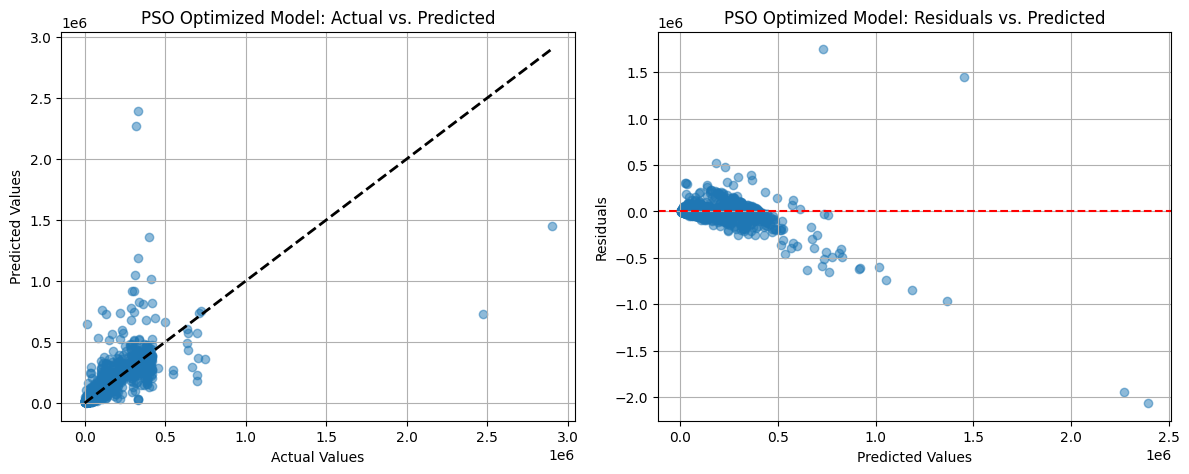

In [10]:
# Define the Final PSO-Optimized Model Architecture
print("\n--- Training Final Model with PSO-Optimized Hyperparameters ---")

pso_optimized_regr_model = Sequential([
    Input(shape=(input_dim,)),
    Dense(best_neurons_l1, activation='relu'),
    Dropout(best_dropout_l1),
    Dense(best_neurons_l2, activation='relu'),
    Dropout(best_dropout_l2),
    Dense(1)
])

# Compile the PSO-Optimized Model
print("\n--- Compiling PSO-Optimized Model ---")
pso_optimized_regr_model.compile(
    optimizer=Adam(learning_rate=best_learning_rate),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

pso_optimized_regr_model.summary()

# Train the PSO-Optimized Model
print("\n--- Training PSO-Optimized Model ---")
pso_final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history_final_pso = pso_optimized_regr_model.fit(
    X_train_processed, y_train, 
    epochs=150,
    batch_size=best_batch_size,
    validation_split=0.2,
    callbacks=[pso_final_early_stopping],
    verbose=1
)

# Evaluate the PSO-Optimized Model
pso_optimized_metrics, _ = evaluate_regression_model(
    "PSO Optimized Model", pso_optimized_regr_model, X_test_processed, y_test
)

In [12]:
metrics_order = ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE', 'MedAE']
comparison_data_regr = {
    "Metric": metrics_order,
    "Baseline Model": [baseline_metrics.get(m, np.nan) for m in metrics_order],
    "PSO Optimized Model": [pso_optimized_metrics.get(m, np.nan) for m in metrics_order]
}
comparison_df_regr = pd.DataFrame(comparison_data_regr)

print("\n\n--- Comparison of Model Performance (Regression Metrics) ---")

format_dict = {
    'Baseline Model': '{:,.2f}',
    'PSO Optimized Model': '{:,.2f}',
    'R2': '{:.4f}', 
    'MAPE': '{:.2f}%'
}

df_for_styling = comparison_df_regr.copy()

mape_index = df_for_styling[df_for_styling['Metric'] == 'MAPE'].index
df_for_styling.loc[mape_index, ['Baseline Model', 'PSO Optimized Model']] *= 1

styled_df = df_for_styling.style.format({
    'Baseline Model': lambda x: f'{x:.4f}' if df_for_styling.loc[x.name, 'Metric'] == 'R2' else f'{x:.2f}%' if df_for_styling.loc[x.name, 'Metric'] == 'MAPE' else f'{x:,.2f}',
    'PSO Optimized Model': lambda x: f'{x:.4f}' if df_for_styling.loc[x.name, 'Metric'] == 'R2' else f'{x:.2f}%' if df_for_styling.loc[x.name, 'Metric'] == 'MAPE' else f'{x:,.2f}'
}).hide(axis='index') 

print("Unstyled Data for reference:")
print(comparison_df_regr.to_string(index=False, float_format="%.4f"))



--- Comparison of Model Performance (Regression Metrics) ---
Unstyled Data for reference:
Metric  Baseline Model  PSO Optimized Model
   MSE 4422001152.0000      6226629120.0000
  RMSE      66498.1289           78908.9926
   MAE      21050.6094           20431.5527
    R2          0.6229               0.4690
  MAPE         37.2333              31.4995
 MedAE       6451.2969            5052.6611


# Analysis of Results

## A Tale of Two Error Types

This is a fascinating result. The **PSO-optimized model** is *worse* on metrics that heavily penalize large errors (**MSE**, **RMSE**) and on its overall explanatory power (**R²**). However, it is *significantly better* on metrics that reflect the "typical" error (**MAE**, **MAPE**) and especially the **median error (MedAE)**.

### What does this mean?

The significant gap between the **median error (MedAE)** and the **mean errors (MAE/RMSE)** strongly suggests that the models are being influenced by **outliers** in the dataset—for instance, very expensive or uniquely priced vehicles.

The PSO-optimized model, with its **larger architecture** and **aggressive learning rate**, appears to have capitalized on this by improving its accuracy on the **majority of the data**. This is supported by:

- A lower **MAE**
- A significantly lower **MAPE** (**31.5% vs. 37.2%**)
- A much-improved **Median Absolute Error**, down to approximately **$5k** from **$6.5k**

However, this focus seems to have made the model **more sensitive to outliers**, causing it to produce a few **catastrophic errors** on some test predictions. These massive errors caused the **MSE** and **RMSE** to balloon and the **R²** to plummet.

---

## Overall Conclusion & Potential Improvements

The PSO found a set of hyperparameters that created a **"high-risk, high-reward"** model. It improved the accuracy for the **bulk of the predictions**, but failed more dramatically on certain outliers compared to the more **conservative baseline model**.

This outcome highlights two crucial aspects of machine learning:

1. **There is often no single "best" model.**  
   The choice depends on the project's goals:
   - If the goal is to have a **stable and reliable model** where large errors are unacceptable, the **baseline model** would be preferable due to its **higher R²** and **lower RMSE**.
   - If the goal is to be **as accurate as possible on the typical case**, even at the risk of a few very bad predictions, the **PSO-optimized model** would be the better choice.

2. **The Importance of Outlier Handling.**  
   A key strategy to improve both models would be to **address outliers before training**. By:
   - Applying a **logarithmic transformation** to the Price, or
   - **Removing extreme data points**,  
   the **loss function (MSE)** would be less skewed by large errors. This would likely allow PSO to find a **more robust** set of hyperparameters, leading to a final model with both **better typical-case performance** and **better stability**.

---

## Final Thoughts

For this project, we have successfully demonstrated that **PSO can explore the hyperparameter space** to find models with different and potentially desirable performance characteristics, even if they don't **uniformly outperform** the baseline on every single metric.

This experiment also powerfully illustrates the **impact of data characteristics and outliers** on model training and evaluation.

This concludes the **regression task for the Autolist dataset**.
